In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## $A(t,T) = \Sigma_i A_i e^{-t/\tau_i} / (1 + e^{-T/2\tau_i})$

In [2]:
def AofT(time,T, ai, taui):
    return ai*np.exp(-time/taui)/(1.+np.exp(-T/(2*taui)))

In [3]:
from SimPEG import *
import sys
sys.path.append("./DoubleLog/")
from plotting import mapDat

In [24]:
class LinearSurvey(Survey.BaseSurvey):
    nD = None
    def __init__(self, time, **kwargs): 
        self.time = time
        self.nD = time.size
        
    def eval(self, f):
        return f

class LinearProblem(Problem.BaseProblem):

    surveyPair = LinearSurvey

    def __init__(self, mesh, G, **kwargs):
        Problem.BaseProblem.__init__(self, mesh, **kwargs)
        self.G = G

    def fields(self, m, f=None):
        return self.G.dot(m)

    def Jvec(self, m, v, f=None):
        return self.G.dot(v)

    def Jtvec(self, m, v, f=None):
        return self.G.T.dot(v)


# Simple exponential basis


$$ \mathbf{A}\mathbf{\alpha} = \mathbf{d}$$

In [25]:
# time = np.cumsum(np.r_[0., 1e-5*np.ones(10), 5e-5*np.ones(10), 1e-4*np.ones(10), 5e-4*np.ones(10), 1e-3*np.ones(10)])
time = np.cumsum(np.r_[0., 1e-5*np.ones(10), 5e-5*np.ones(10),1e-4*np.ones(5)])
M = 41
tau = np.logspace(-4.1, -1, M)

In [26]:
N = time.size
A = np.zeros((N, M))
for j in range(M):
    A[:,j] = np.exp(-time/tau[j])

In [27]:
mtrue = np.zeros(M)

In [28]:
np.random.seed(1)
inds = np.random.random_integers(0, 41, size=5)
mtrue[inds] = np.r_[-0.2, 2, 1, 4, 5]

/Users/sgkang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 41 + 1) instead
  from ipykernel import kernelapp as app


In [29]:
out = np.dot(A,mtrue)

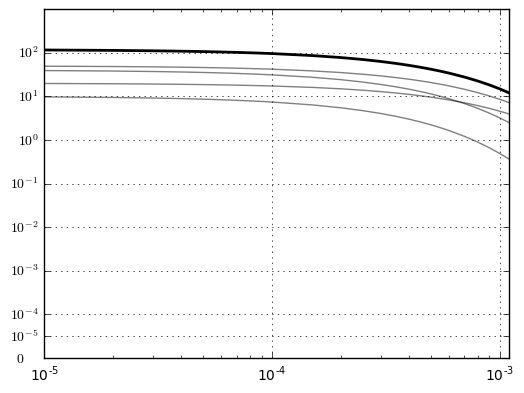

In [30]:
fig = plt.figure(figsize=(6,4.5))
ax = plt.subplot(111)

for i, ind in enumerate(inds):
    temp, dum, dum = mapDat(mtrue[inds][i]*np.exp(-time/tau[ind]), 1e-5, stretch=2)
    plt.semilogx(time, temp, 'k', alpha = 0.5)    
outmap, ticks, tickLabels = mapDat(out, 1e-5, stretch=2)    
ax.semilogx(time, outmap, 'k', lw=2)
ax.set_yticks(ticks)
ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
ax.set_ylim(ticks.min(), ticks.max())
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [31]:
# from pymatsolver import MumpsSolver

In [32]:
mesh = Mesh.TensorMesh([M])
prob = LinearProblem(mesh, A)
survey = LinearSurvey(time)
survey.pair(prob)
survey.makeSyntheticData(mtrue, std=0.01)
# survey.dobs = out
reg = Regularization.BaseRegularization(mesh)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./(0.05*abs(survey.dobs)+0.05*1e-2)
opt = Optimization.ProjectedGNCG(maxIter=20)
# opt = Optimization.InexactGaussNewton(maxIter=20)
opt.lower = -1e-10
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.beta = 1e-4
beta = Directives.BetaSchedule()
beta.coolingFactor = 2
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, target])
m0 = np.zeros_like(survey.mtrue)
mrec = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-04  5.18e+03  0.00e+00  5.18e+03    1.10e+04      0              
   1  1.00e-04  9.71e+02  5.19e+00  9.71e+02    3.22e+00      0              
   2  1.00e-04  1.35e+02  4.51e+00  1.35e+02    3.00e+00      0              
   3  5.00e-05  8.95e+01  5.60e+00  8.95e+01    3.35e+00      0   Skip BFGS  
   4  5.00e-05  5.10e+01  5.28e+00  5.10e+01    1.80e+01      0   Skip BFGS  
   5  5.00e-05  4.72e+01  6.85e+00  4.72e+01    3.70e+00      1              
   6  2.50e-05  1.86e+01  6.32e+00  1.86e+01    2.03e+0

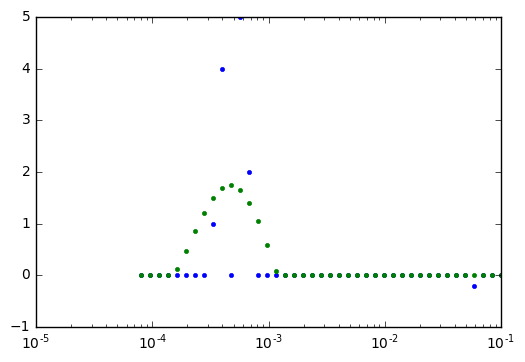

In [33]:
plt.semilogx(tau, mtrue, '.')
plt.semilogx(tau, mrec, '.')

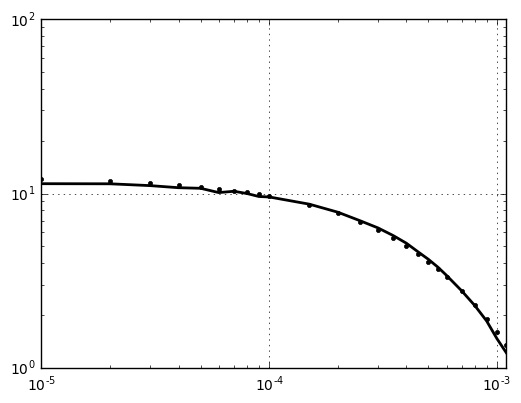

In [34]:
fig = plt.figure(figsize=(6,4.5))
ax = plt.subplot(111)
obsmap, ticks, tickLabels = mapDat(survey.dobs, 1e0, stretch=2)    
predmap, dum, dum = mapDat(invProb.dpred, 1e0, stretch=2)    
ax.loglog(time, survey.dobs, 'k', lw=2)
ax.loglog(time, invProb.dpred, 'k.', lw=2)
# ax.set_yticks(ticks)
# ax.set_yticklabels(tickLabels)
# ax.set_ylim(ticks.min(), ticks.max())
# ax.set_ylim(ticks.min(), ticks.max())
ax.set_xlim(time.min(), time.max())
ax.grid(True)

In [15]:
time = np.cumsum(np.r_[0., 1e-5*np.ones(10), 5e-5*np.ones(10), 1e-4*np.ones(10), 5e-4*np.ones(10), 1e-3*np.ones(10)])
N = time.size
A = np.zeros((N, M))
for j in range(M):
    A[:,j] = np.exp(-time/tau[j])

In [16]:
mfund = mtrue.copy()
mfund[mfund<0.] = 0.
obs = np.dot(A, mtrue)
fund = np.dot(A, mfund)
pred = np.dot(A, mrec)

In [17]:
ip = obs-fund
ipobs = obs-pred

(1.0000000000000001e-05, 0.016600000000000007)

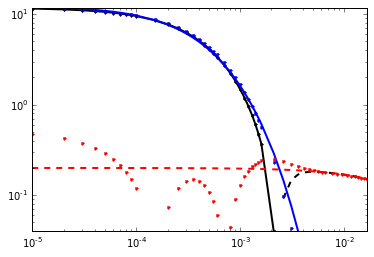

In [19]:
plt.loglog(time, obs, 'k.-', lw=2)
plt.loglog(time, -obs, 'k--', lw=2)
plt.loglog(time, fund, 'b.', lw=2)
plt.loglog(time, pred, 'b-', lw=2)
plt.loglog(time, -ip, 'r--', lw=2)
plt.loglog(time, abs(ipobs), 'r.', lw=2)
plt.ylim(abs(obs).min(), abs(obs).max())
plt.xlim(time.min(), time.max())

## Range of tau is really important to fit ...